In [1]:
import os
import sys
import pickle
import string

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering


from utils import *
from AnalyseDefects import AnalyseDefects

plt.style.use('sg_article')

In [24]:
def gen_analysis_dict(LL, mode):

    dshort = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05', \
              suffix = "short", priority = -1, LX = LL, Nframes = 181)
    dlong = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_long', \
                suffix = "long", priority = 1, LX = LL, Nframes = 400)
    dvery_long = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long',\
                    suffix = "very_long", priority = 2, LX = LL, Nframes = 1500)
    dvery_long2 = dict(path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nematic_analysis{LL}_LL0.05_very_long_v2',\
                    suffix = "very_long2", priority = 3, LX = LL, Nframes = 1500)

    if mode == 'all':
        if LL == 2048:
            defect_list = [dshort, dlong]
        else:
            defect_list = [dshort, dlong, dvery_long, dvery_long2] if LL in [256] else [dshort, dlong, dvery_long]
    else:
        defect_list = [dshort]
    
    return defect_list

def extract_clp_results(clustering_dict, Nframes, Nexp, rmax_list, conv_list, act_list, act_dir_list, save_path = None):
    """
    Analyse the defects for all the input folders
    """

    LX = clustering_dict['LX']
    suffix = clustering_dict['suffix']
    Nwindows = len(rmax_list)
    # create arrays to store the clustering data
    cluster_arr = np.nan * np.zeros([Nframes, Nwindows, 3, len(act_list), Nexp])
    
    for i, (act, act_dir) in enumerate(zip(act_list, act_dir_list)):

        exp_list = []
        exp_dir_list = []

        for file in os.listdir(act_dir):
            exp_count = file.split('_')[-1]
            exp_list.append(int(exp_count))
            exp_dir_list.append(os.path.join(act_dir, file))

        # sort the activity list and the activity directory list
        exp_list, exp_dir_list = zip(*sorted(zip(exp_list, exp_dir_list)))

        for j, (exp, exp_dir) in enumerate(zip(exp_list, exp_dir_list)):
            cluster_arr[:,:,:,i,j] = np.load(os.path.join(exp_dir, 'cl_arr.npy'))[-Nframes:]

    if save_path is not None:
        if not os.path.isdir(save_path):
            os.makedirs(save_path)
        np.save(os.path.join(save_path, f'arr{suffix}.npy'), cluster_arr)
    return cluster_arr

def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        defect_positions[i] = *defect['pos'], defect['charge'] if return_charge else defect['pos']
    return defect_positions

def get_clustering_signed(top_defect_list, method, rmax_list, method_kwargs, save = False, save_path = None):
    """
    
    Parameters:
    -----------
    Returns:
    --------
    """
  
    Nframes = len(top_defect_list)
    Nwindows = len(rmax_list)

    cl_arr = np.nan * np.ones([Nframes, Nwindows, 3])
   
    for frame, defects in enumerate(top_defect_list):
        # Get defect array for frame
        defect_arr = get_defect_arr_from_frame(defects, return_charge = True)
        defect_positions = defect_arr[:, :-1]
        defect_charges = defect_arr[:, -1] 

        if defect_positions is None:
            continue

        for i, rmax in enumerate(rmax_list):
            cst = method(distance_threshold = rmax, **method_kwargs)
            labels = cst.fit_predict(defect_positions)

            Ncl = np.max(labels) + 1
            Qc_arr = np.zeros(Ncl)

            for N in range(Ncl):
                mask = (labels == N)
                Qc = np.sum(defect_charges[mask])
                Qc_arr[N] = Qc
 
            all_neutral = float(np.all(Qc_arr == 0))
            Qcl = np.sum(np.abs(Qc_arr)) / Ncl
            cl_arr[frame, i] = [Ncl, Qcl, all_neutral]

    if save:
        # save labels list
        save_path = save_path if save_path is not None else 'labels_list.pkl'
        np.save(save_path, cl_arr)
    return cl_arr

In [157]:
extract = False

LX = 2048
output_path = f'data\\nematic_analysis{LX}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LX, mode)
ad = AnalyseDefects(defect_list, output_path=output_path)


base_path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na{LX}'
out_path = f'C:\\Users\\Simon Andersen\\Projects\\Projects\\Thesis\\NematicAnalysis\\data\\na{LX}clp'
Nframes_l = 400 if LX < 2048 else 180
Nframes_vl = 1500 if LX < 2048 else 400
rmax_list = np.arange(10, 500)

d_cluster_l = dict(path = base_path + '_clp', \
            suffix = "_clp", priority = 1, LX = LX, Nframes = Nframes_l)
d_cluster_vl = dict(path = base_path + 'l_clp', \
            suffix = "_l_clp", priority = 1, LX = LX, Nframes = Nframes_vl)
    
    
Nexp_l, act_l, act_dir_l = gen_clustering_metadata(d_cluster_l['path'])
Nexp_vl, act_vl, act_dir_vl = gen_clustering_metadata(d_cluster_vl['path'])

if extract:
    act_idx = ad.act_list[0].index(act_l[0])
    clp_arr = extract_clp_results(d_cluster_l, Nframes_l, len(Nexp_l), 
                                rmax_list, ad.conv_list[0][act_idx:], act_l, act_dir_l,
                                save_path=out_path)
    clp_arr_l = extract_clp_results(d_cluster_vl, Nframes_vl, len(Nexp_vl), 
                                rmax_list, ad.conv_list[-1], act_vl, act_dir_vl,
                                save_path=out_path)
else:
    clp_arr = np.load(os.path.join(out_path, 'arr_clp.npy'))
    clp_arr_l = np.load(os.path.join(out_path, 'arr_l_clp.npy'))

In [84]:
4%2

0

In [86]:
(3*np.ones(3)) % 2 == 0

array([False, False, False])

In [102]:
LX = 1024
output_path = f'data\\nematic_analysis{LX}_LL0.05'
mode = 'all' # 'all' or 'short'

defect_list = gen_analysis_dict(LX, mode)
ad = AnalyseDefects(defect_list, output_path=output_path)


In [108]:
def_arr = ad.get_arrays_full(0)[0]
act_list = ad.act_list[0]
act_idx = act_list.index(0.025)
def_arr[:20,act_idx,2]

array([1963., 1948., 1961., 1968., 1967., 1949., 1943., 1957., 1944.,
       1931., 1923., 1935., 1938., 1937., 1948., 1929., 1903., 1906.,
       1904., 1924.])

In [ ]:
for N in range(3):
    def_arr = ad.get_arrays_full(N)[0]
    for i, act in enumerate(ad.act_list[N]):

        mask = (def_arr[:,i,:].flatten() % 2 == 1)
        print(act, mask.sum(), mask.sum()/len(mask))
     #   print(def_arr[:,i,:].flatten()[mask][:10])

In [158]:
ad.conv_list

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 array([100, 275,   0,  50,   0, 150])]

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11280\1321096830.py:6: RuntimeWarning: Mean of empty slice
  qav = np.nanmean(clp_arr[ff_idx:, :, 1, i, :], axis=(0,-1))


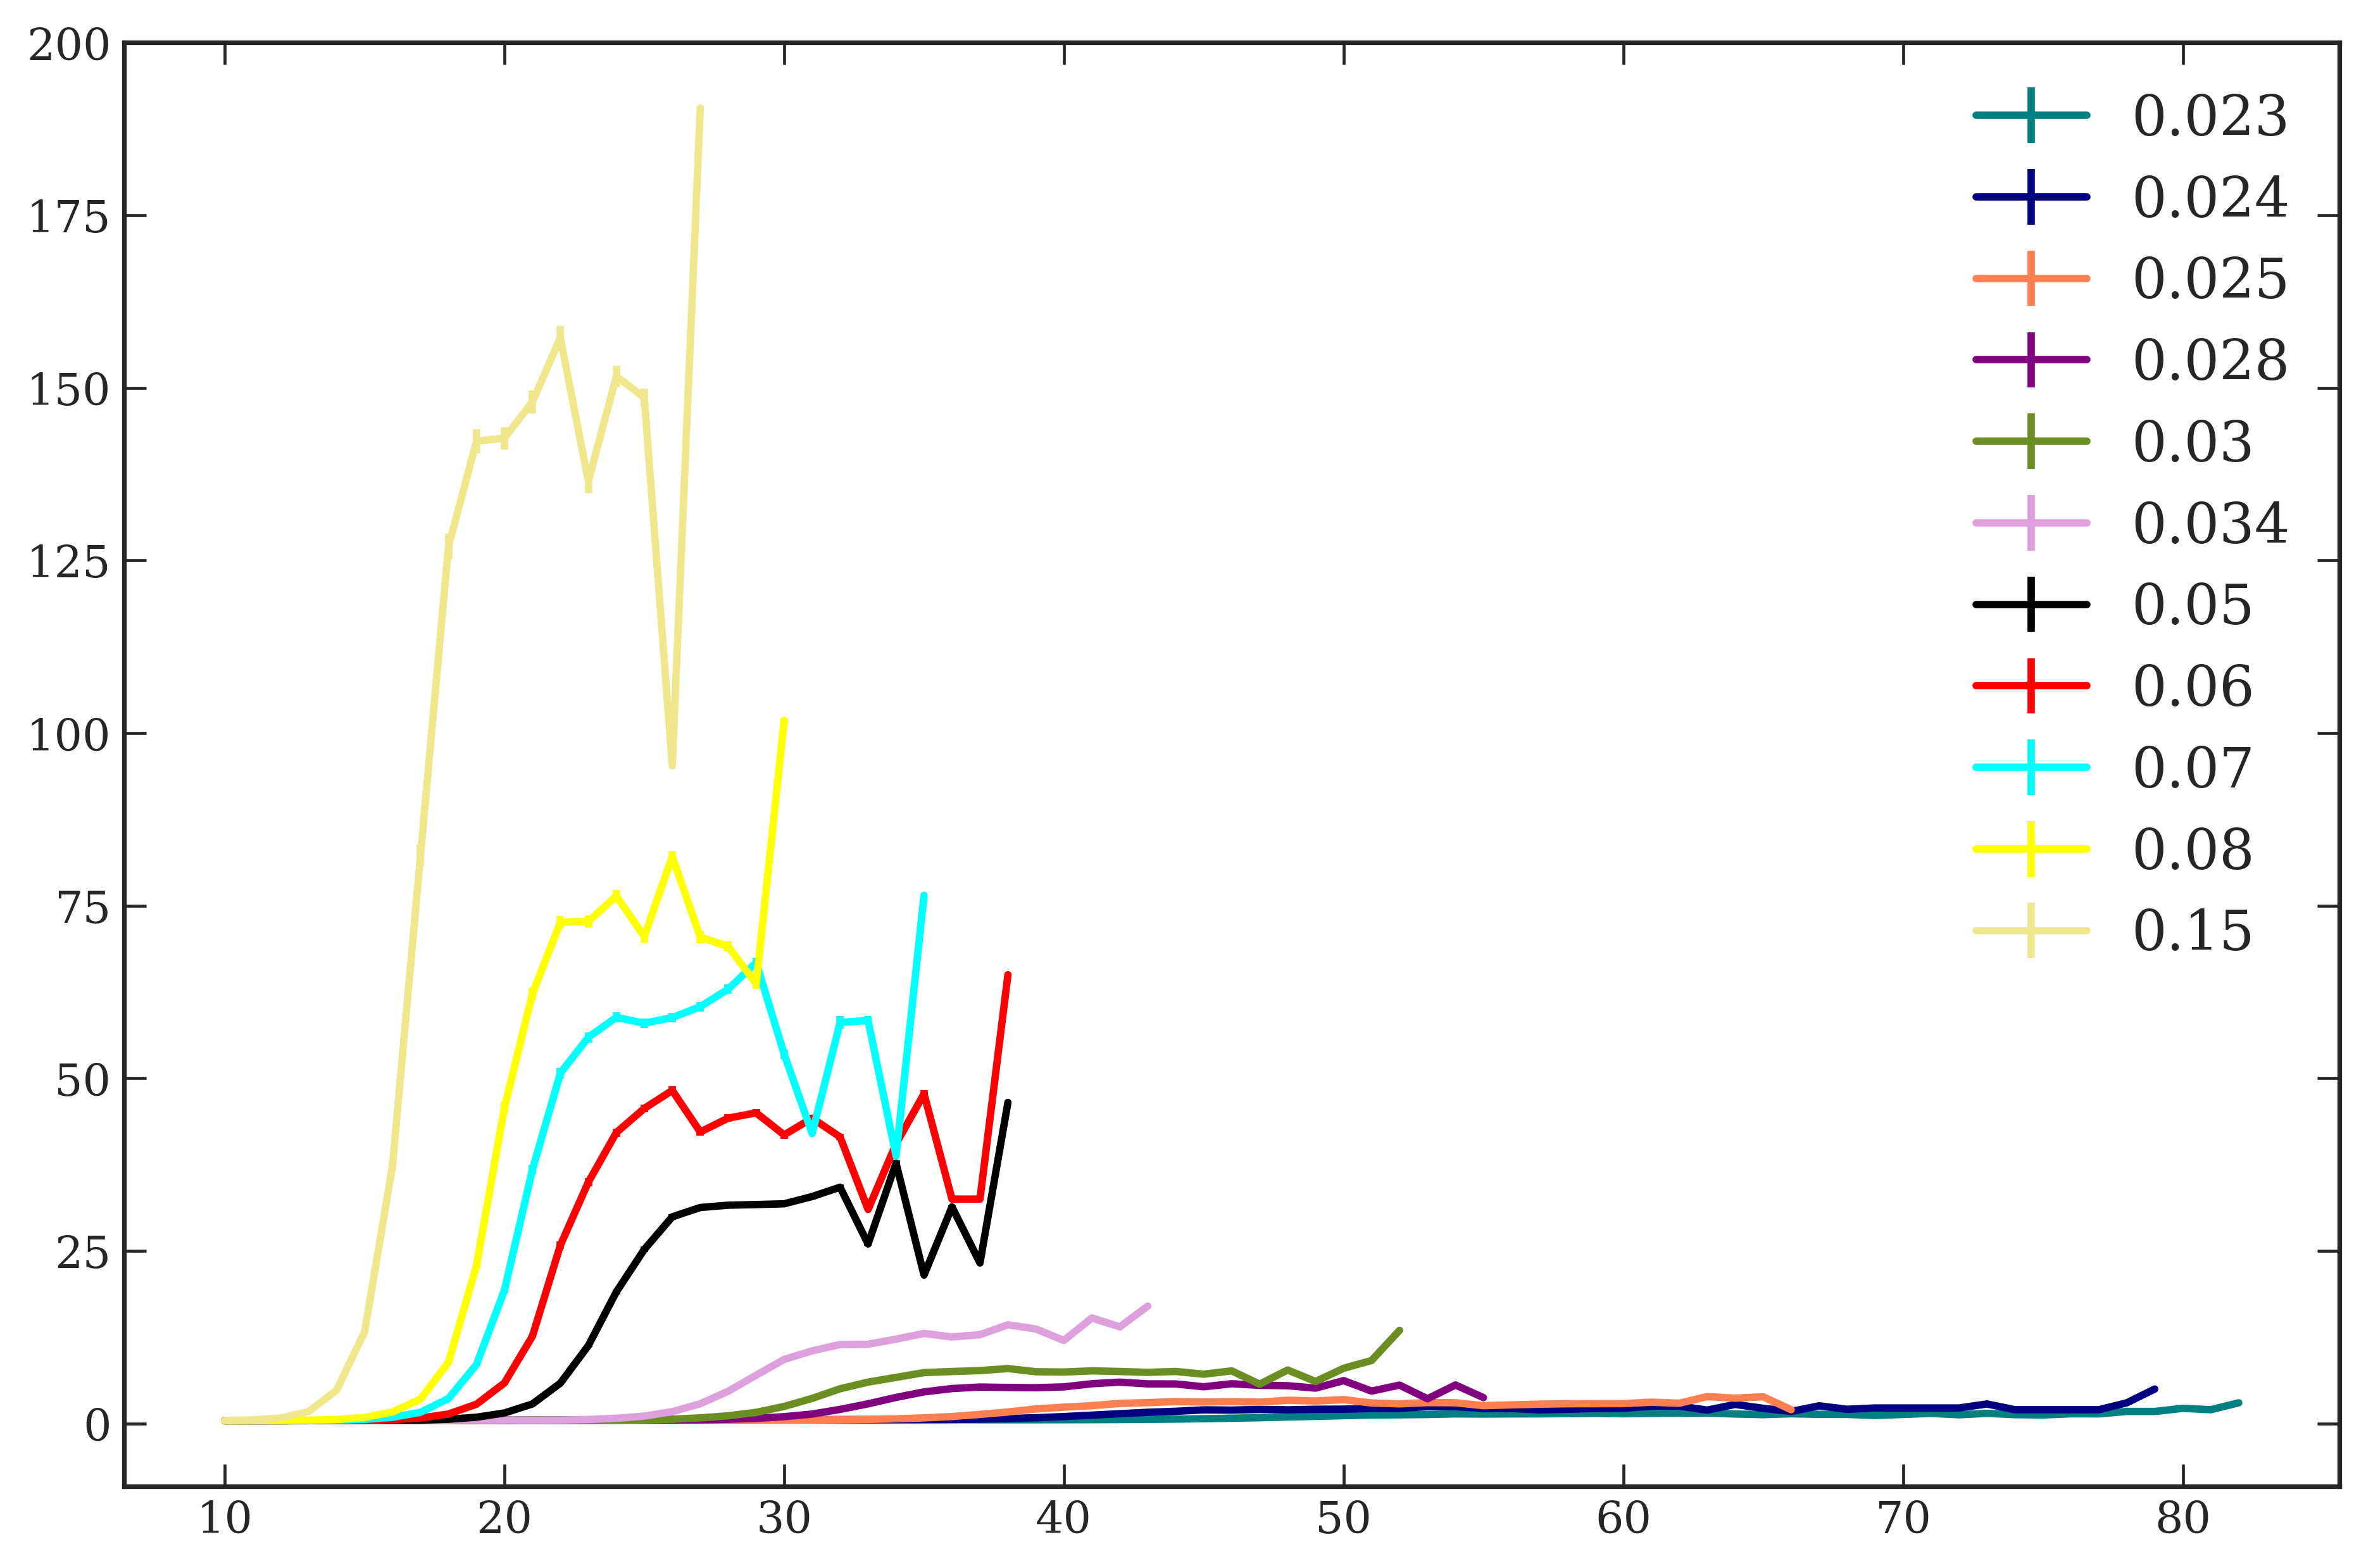

In [162]:
fi, ax = plt.subplots()
for j, act_list in enumerate([act_l]):
    conv_list = ad.conv_list[0]
    for i, act in enumerate(act_list):
        ff_idx = conv_list[i]
        qav = np.nanmean(clp_arr[ff_idx:, :, 1, i, :], axis=(0,-1))
        qstd = np.nanstd(clp_arr[ff_idx:, :, 1, i, :], axis=(0,-1)) \
        / np.sqrt((Nframes_l - ff_idx) * len(Nexp_l))

        ax.errorbar(rmax_list, qav, qstd, label=f'{act}')

ax.legend()
#ax.set_ylim(0,25)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11280\3078115704.py:6: RuntimeWarning: Mean of empty slice
  qav = np.nanmean(clp_arr_l[ff_idx:, :, 1, i, :], axis=(0,-1))
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


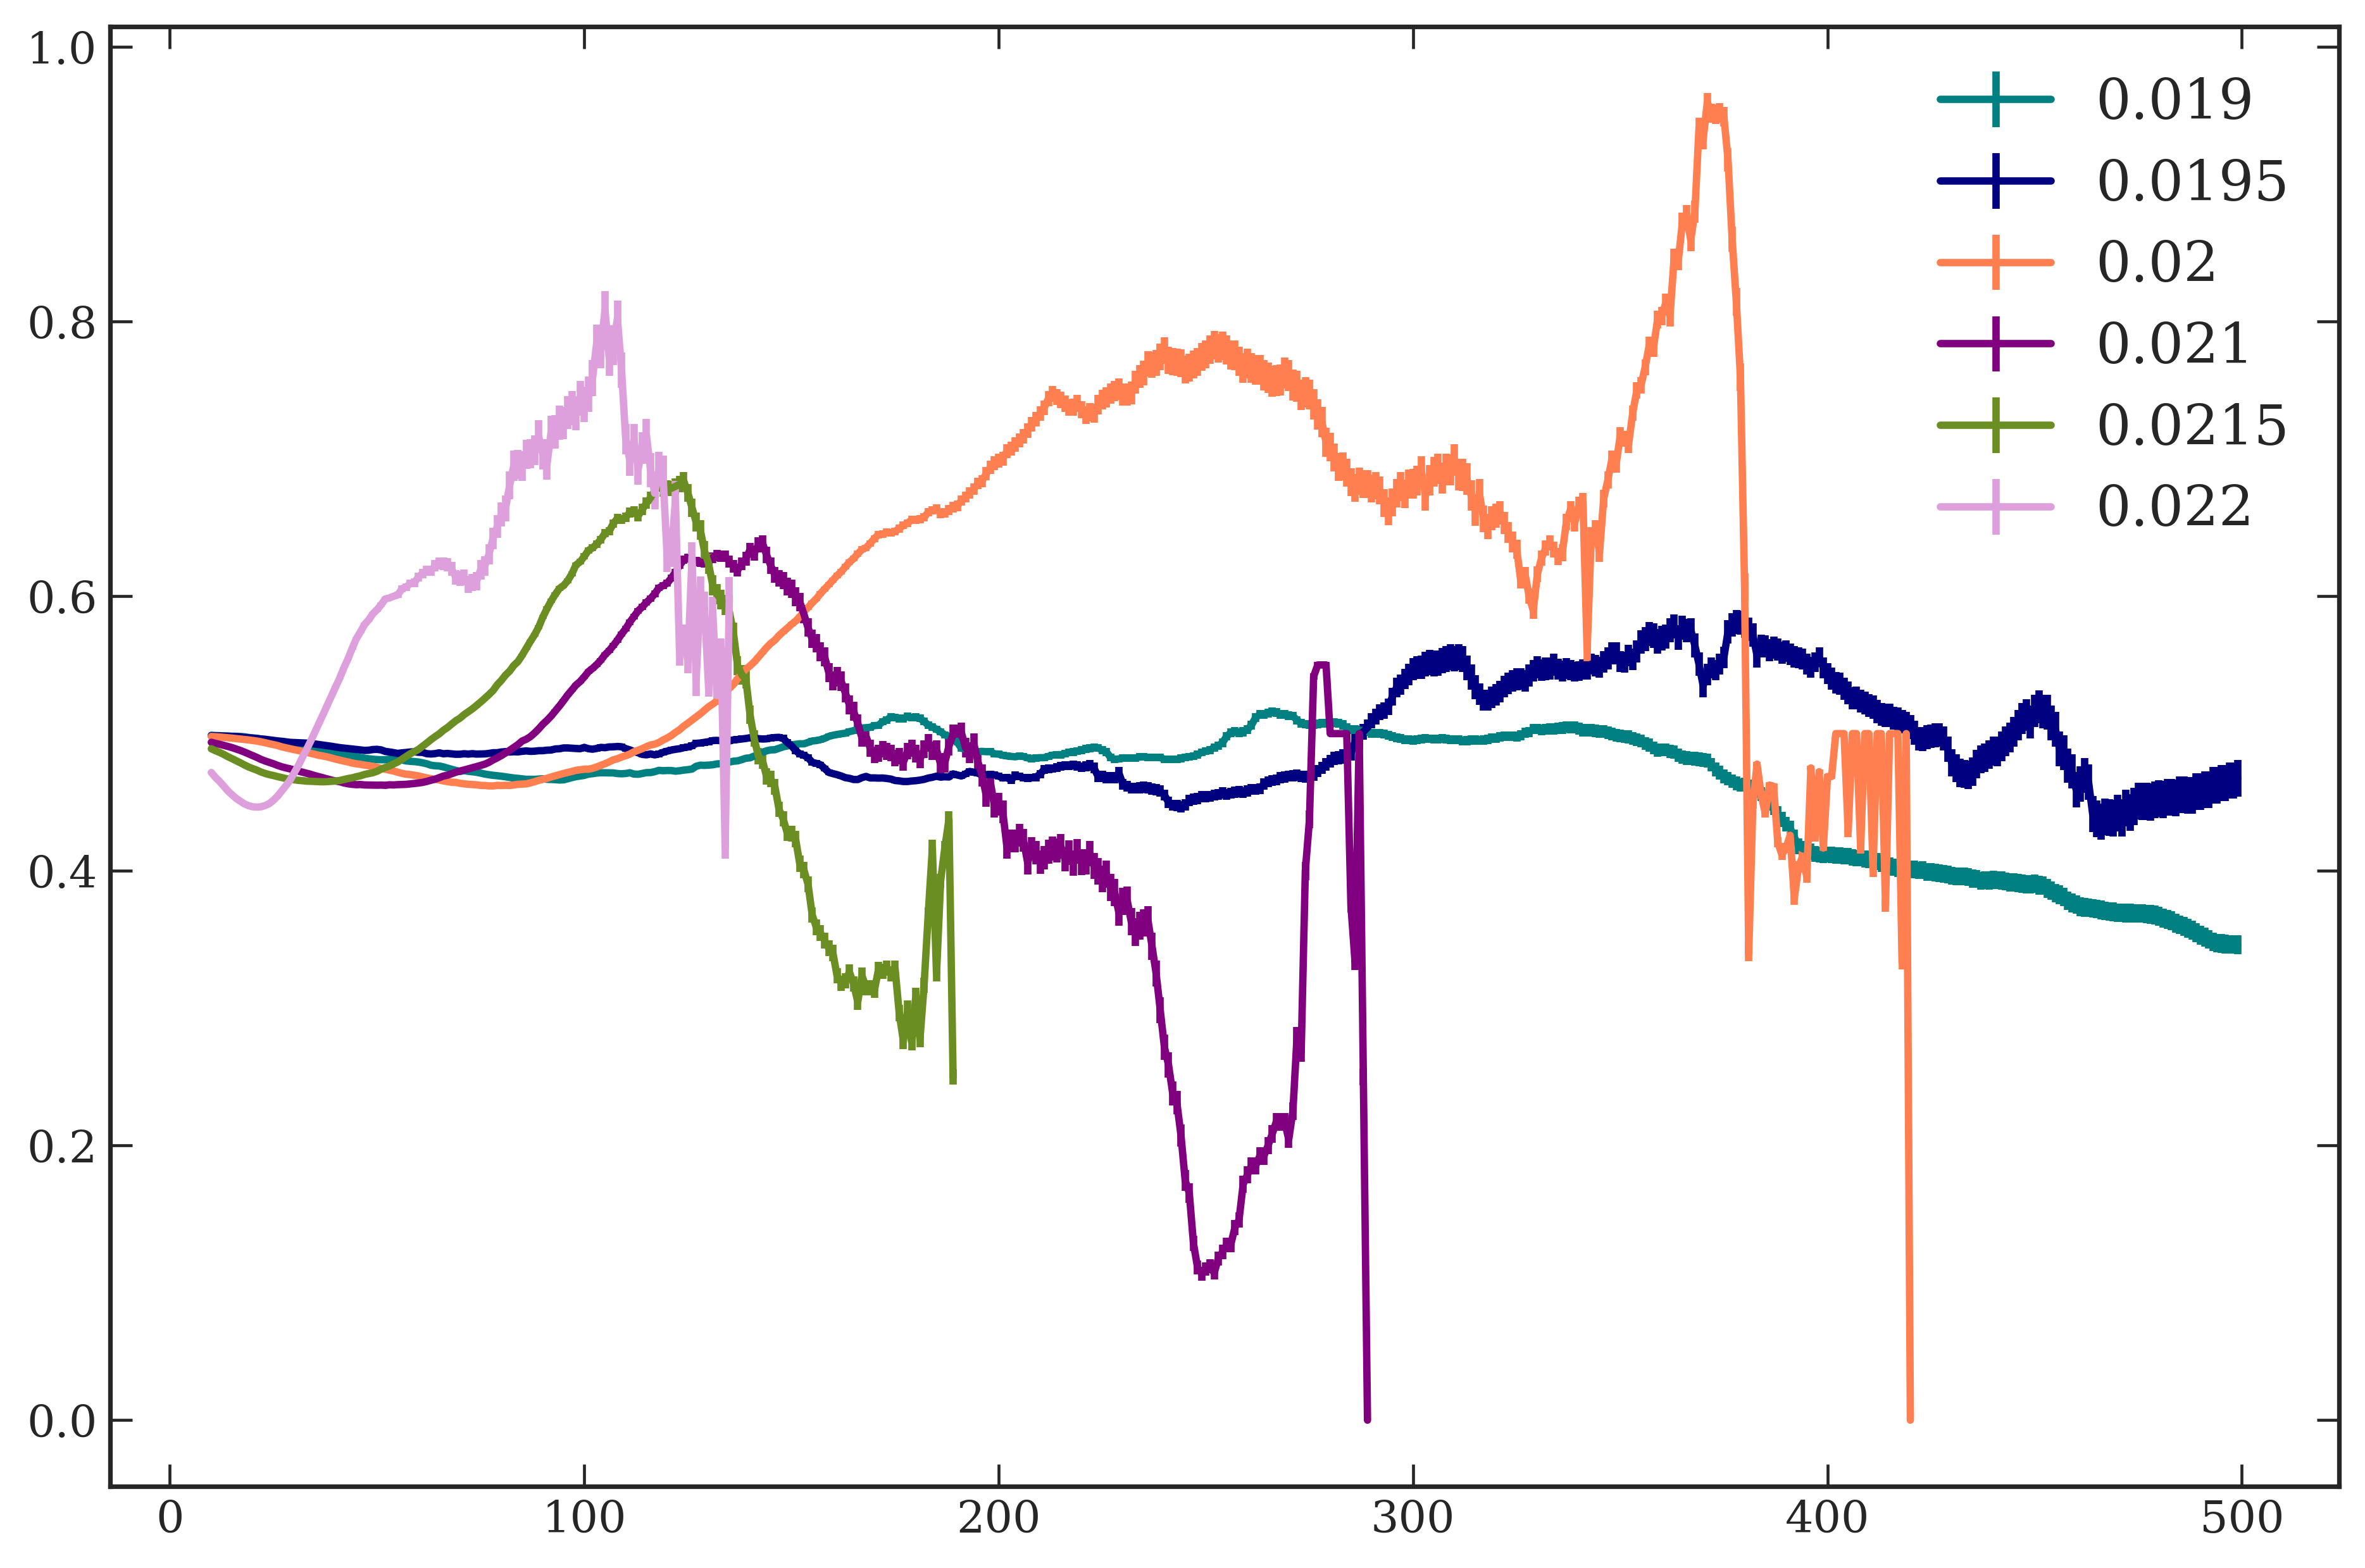

In [161]:
fi, ax = plt.subplots()
for j, act_list in enumerate([act_vl]):
    conv_list = ad.conv_list[-1]
    for i, act in enumerate(act_list):
        ff_idx = conv_list[i]
        qav = np.nanmean(clp_arr_l[ff_idx:, :, 1, i, :], axis=(0,-1))
        qstd = np.nanstd(clp_arr_l[ff_idx:, :, 1, i, :], axis=(0,-1)) \
        / np.sqrt((Nframes_vl - ff_idx) * len(Nexp_vl))

        ax.errorbar(rmax_list, qav, qstd, label=f'{act}')

ax.legend()
#ax.set_ylim(0,25)

C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_11280\3149932660.py:5: RuntimeWarning: Mean of empty slice
  qav = np.nanmean(clp_arr_l[150:, :, 1, act_idx, N], axis=0)


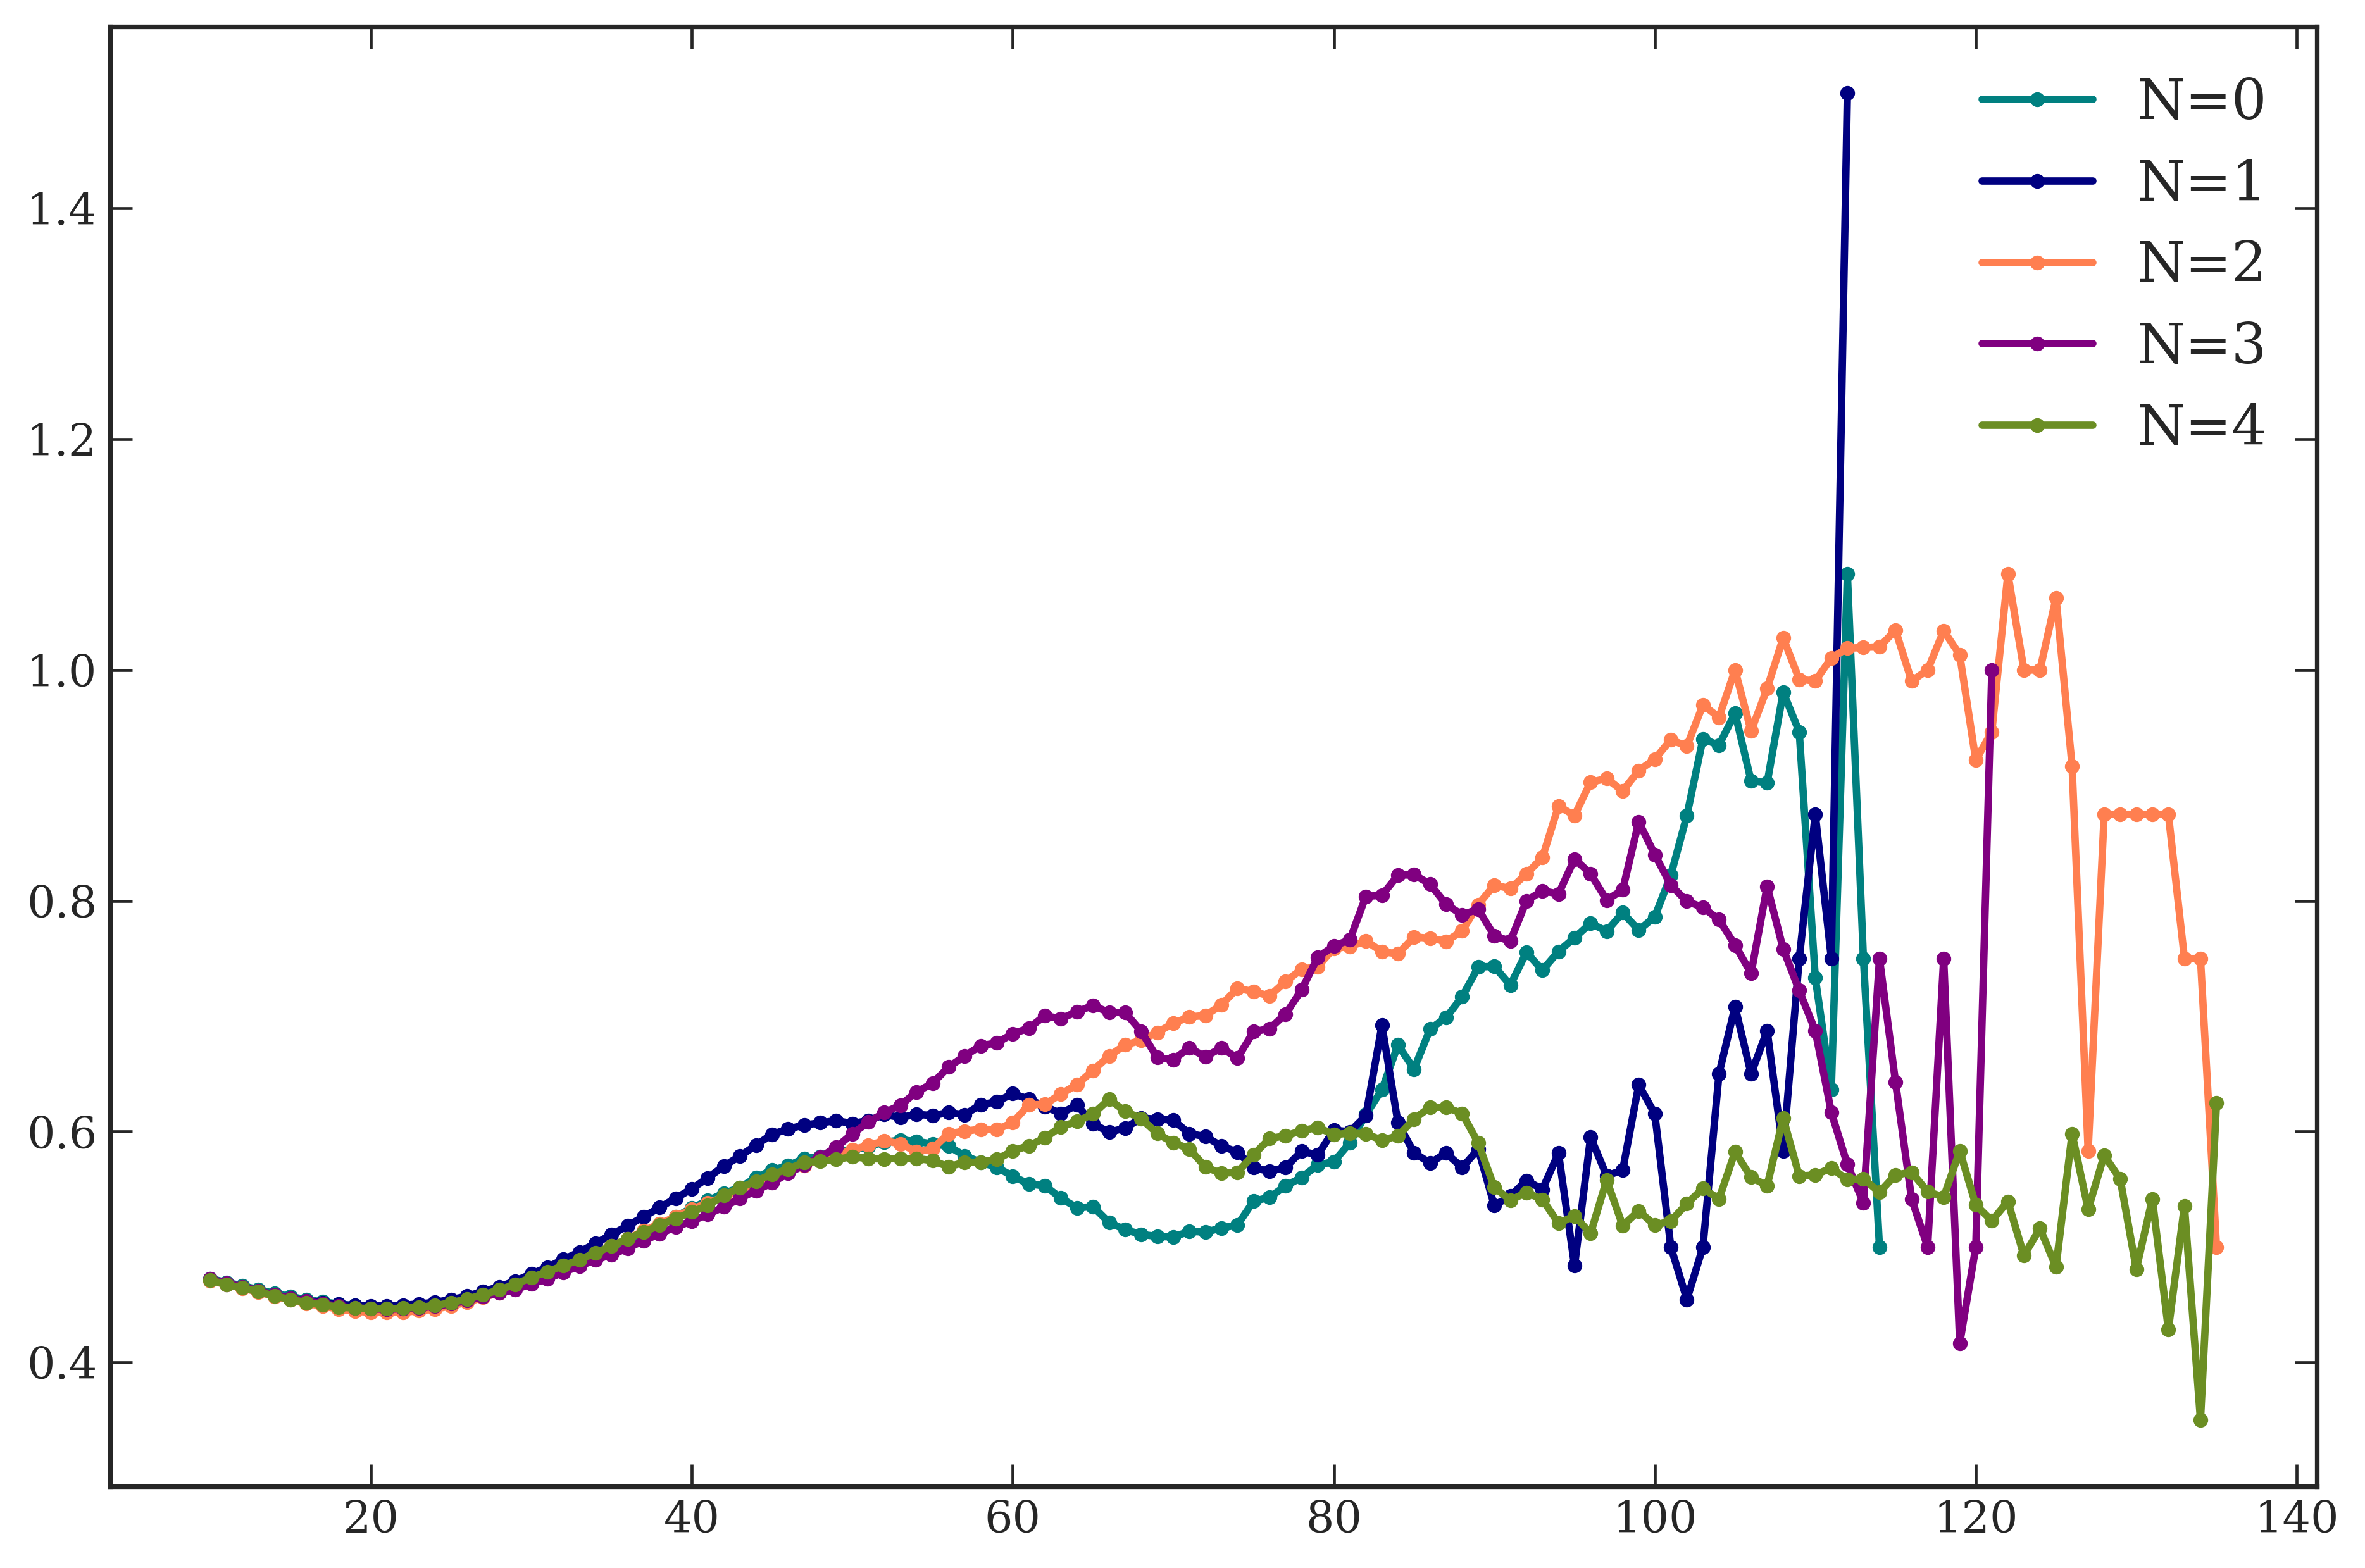

In [156]:
act_idx=-1
last_charge = np.zeros((Nframes_vl, 5))
Nsteps = 400
for N in range(5):
    qav = np.nanmean(clp_arr_l[150:, :, 1, act_idx, N], axis=0)
    plt.plot(rmax_list, qav, '.-', label=f'N={N}')

plt.legend()

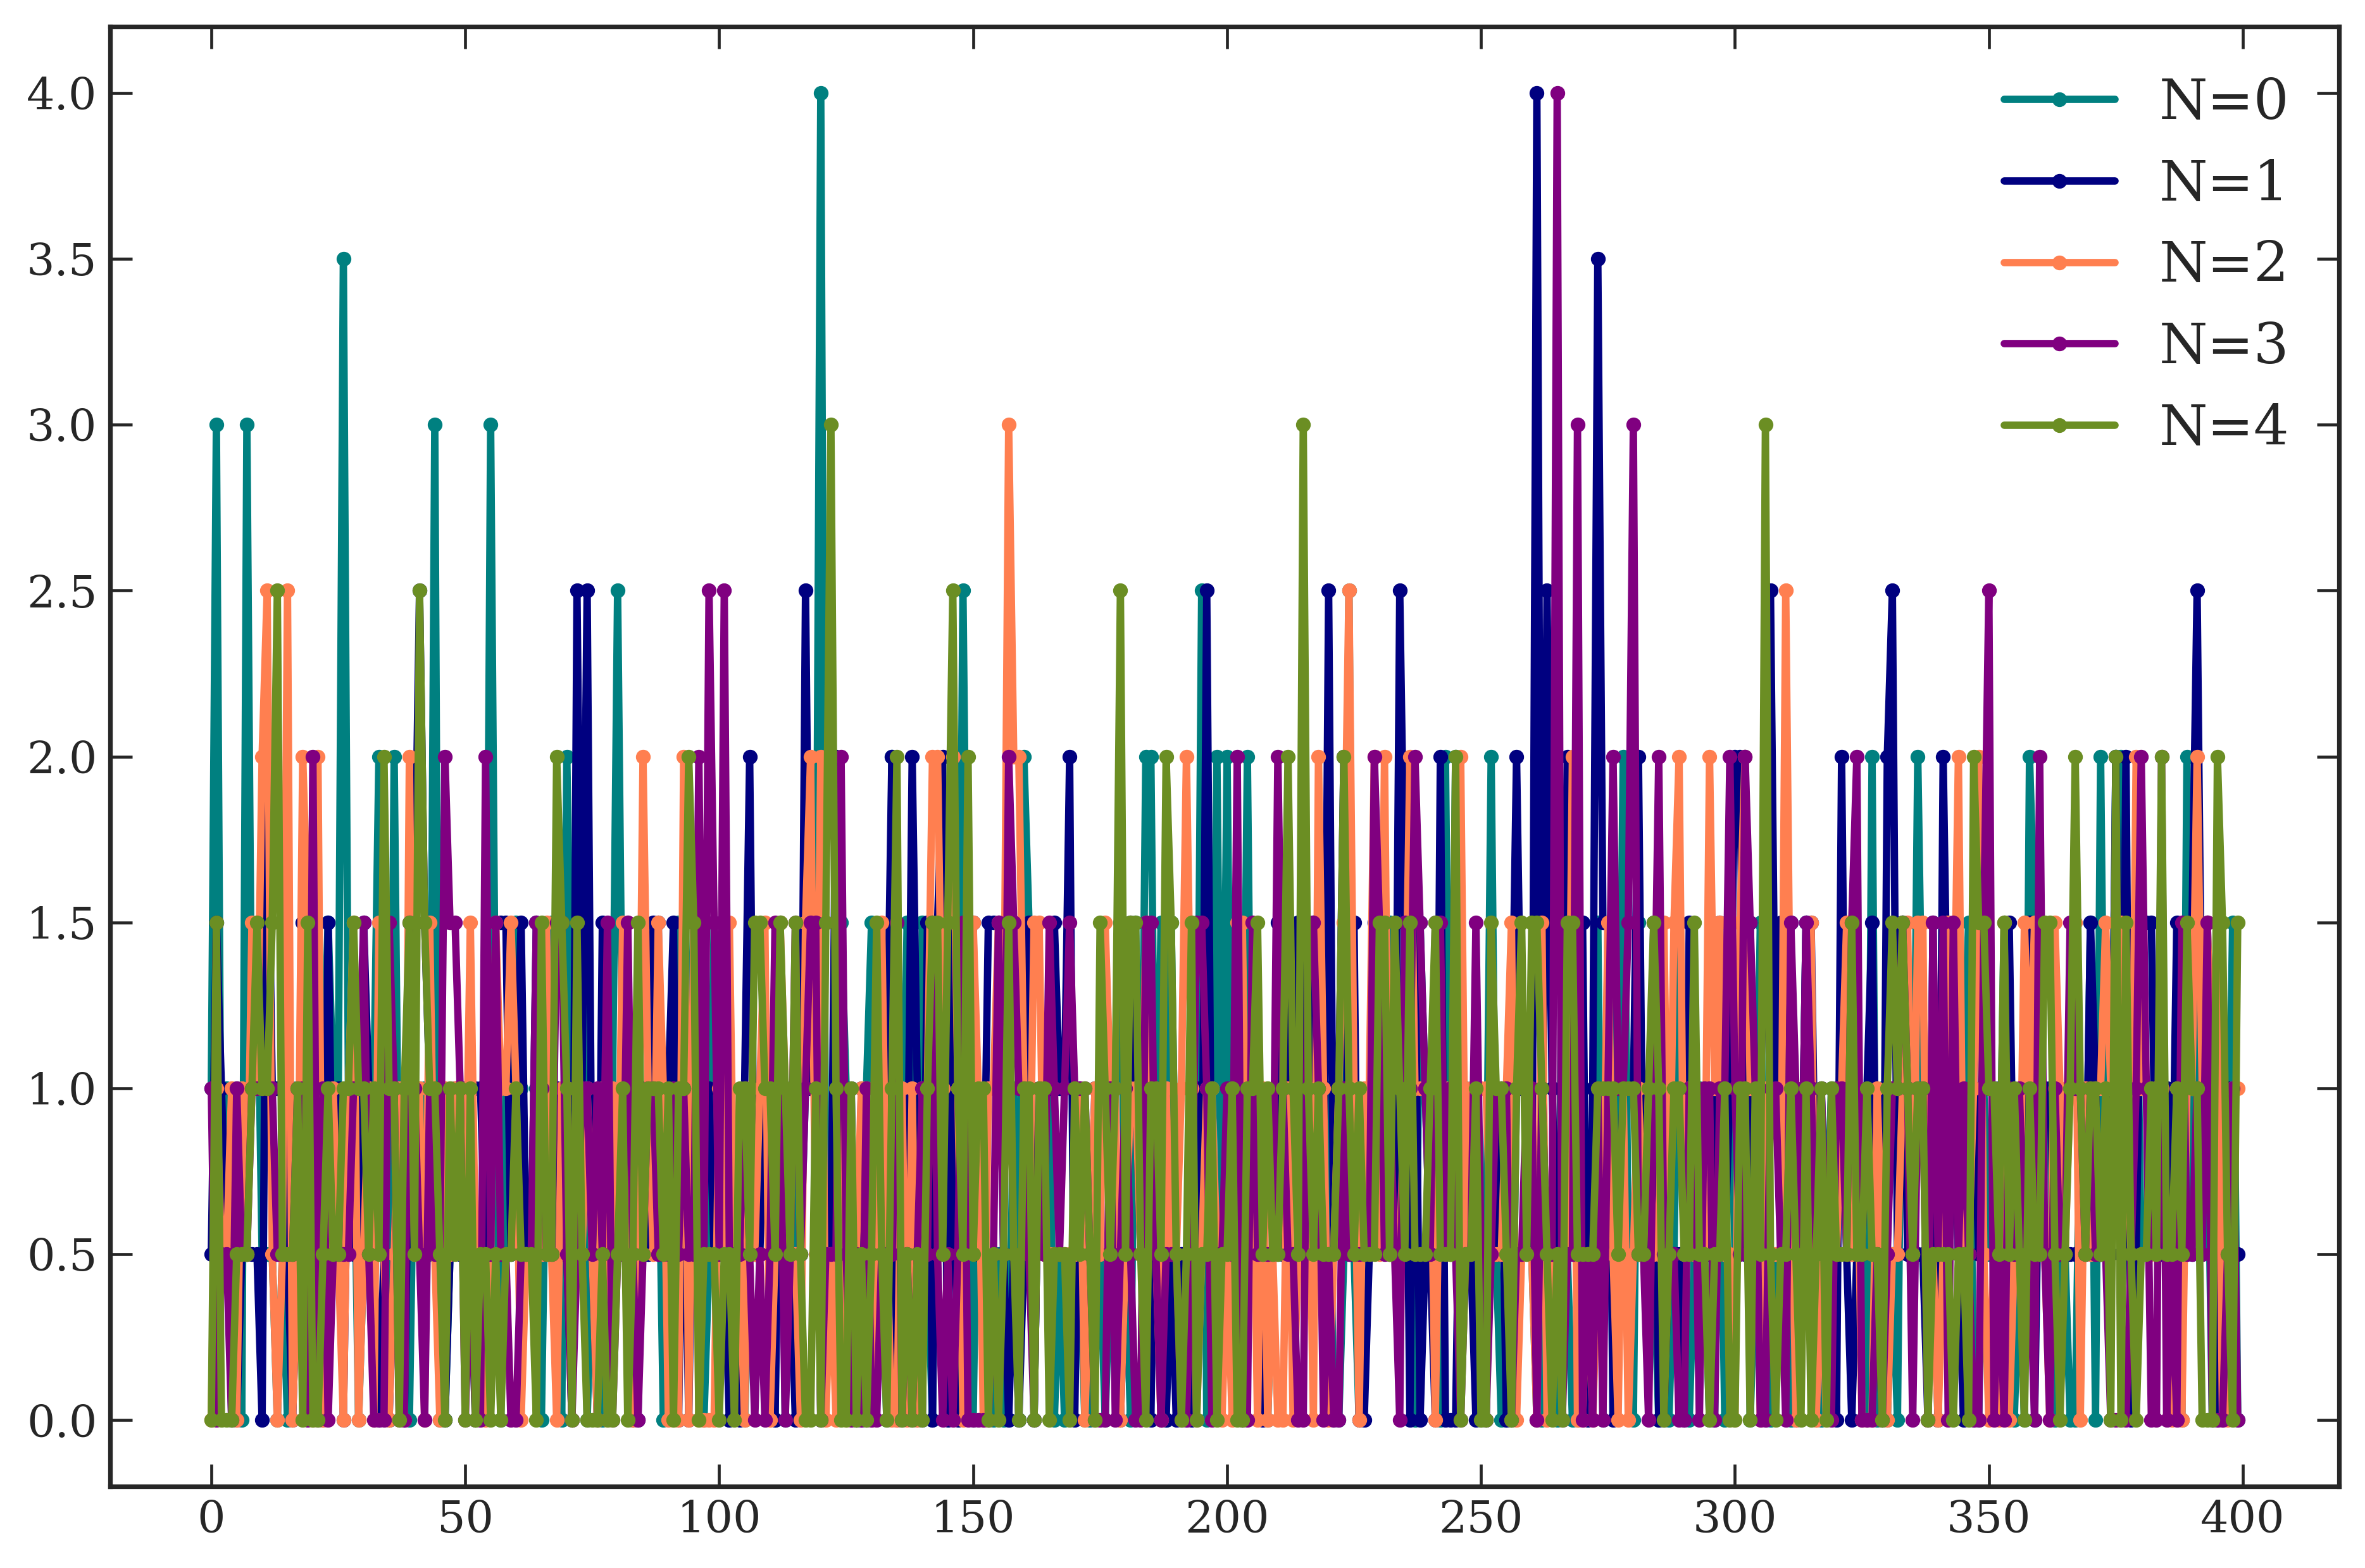

In [152]:
act_idx=-1
last_charge = np.zeros((Nframes_vl, 5))
Nsteps = 400
for N in range(5):
    for f in range(Nsteps):
        non_nan = ~np.isnan(clp_arr_l[f,:,0,act_idx,N])
        last_charge[f,N]=clp_arr_l[f,non_nan,1,act_idx,N][-1]

    plt.plot(np.arange(Nsteps), last_charge[:Nsteps, N], '.-', label=f'N={N}',)
plt.legend()

In [125]:
path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\na512l_cl\\analysis_zeta_0.024\\zeta_0.024_counter_0'
path = f'C:\\Users\\Simon Andersen\\Documents\\Uni\\Speciale\\Hyperuniformity\\nclust1024'

d_cluster = dict(path = path, suffix = "cluster", priority = -1, LX = 512, Nframes = 180)
output_path = 'data\\nematic_analysis512_LL0.05\\cluster' 
if not os.path.exists(output_path):
    os.makedirs(output_path)

rm_list = []
#for i, file in enumerate(os.listdir(os.path.join(path, os.listdir(path)[0]))):
#    if file.startswith('labels'):
 #       rm_list.append(int(file.split('rm')[-1].split('.')[0]))
#dpath = os.path.join(path, os.listdir(path)[0])
with open(os.path.join(path, 'defect_positions.pkl'), 'rb') as f:
    defect_positions = pickle.load(f)


In [59]:
def get_defect_arr_from_frame(defect_dict, return_charge = False):
    """
    Convert dictionary of defects to array of defect positions
    Parameters:
    -----------
    defect_dict : dict
        Dictionary of defects positions and charges
    return_charge : bool
        If True, return defect charges as well

    Returns:
    --------
    defect_positions : np.ndarray
        Array of defect positions
    defect_charges : np.ndarray
    """

    Ndefects = len(defect_dict)
    if Ndefects == 0:
        return None
    
    defect_positions = np.empty([Ndefects, 3 if return_charge else 2])

    for i, defect in enumerate(defect_dict):
        defect_positions[i] = *defect['pos'], defect['charge'] if return_charge else defect['pos']
    return defect_positions

def get_clustering_signed(top_defect_list, method, rmax_list, method_kwargs, save = False, save_path = None):
    """
    
    Parameters:
    -----------
    Returns:
    --------
    """
  
    Nframes = len(top_defect_list)
    Nwindows = len(rmax_list)

    cl_arr = np.nan * np.ones([Nframes, Nwindows, 3])
   
    for frame, defects in enumerate(top_defect_list):
        # Get defect array for frame
        defect_arr = get_defect_arr_from_frame(defects, return_charge = True)
        defect_positions = defect_arr[:, :-1]
        defect_charges = defect_arr[:, -1] 

        if defect_positions is None:
            continue

        for i, rmax in enumerate(rmax_list):
            cst = method(distance_threshold = rmax, **method_kwargs)
            labels = cst.fit_predict(defect_positions)

            Ncl = np.max(labels) + 1
            Qc_arr = np.zeros(Ncl)

            for N in range(Ncl):
                mask = (labels == N)
                Qc = np.sum(defect_charges[mask])
                Qc_arr[N] = Qc
 
            all_neutral = float(np.all(Qc_arr == 0))
            Qcl = np.sum(np.abs(Qc_arr)) / Ncl
            cl_arr[frame, i] = [Ncl, Qcl, all_neutral]

    if save:
        # save labels list
        save_path = save_path if save_path is not None else 'labels_list.pkl'
        np.save(save_path, cl_arr)
    return cl_arr

In [ ]:
for f in range(150):
    defect_arr = get_defect_arr_from_frame(defect_positions[f], return_charge = True)

    defect_charges = defect_arr[:, -1] 
    qtot = np.nansum(defect_charges)
    if qtot != 0.0:
        print(f, qtot)


<ErrorbarContainer object of 3 artists>

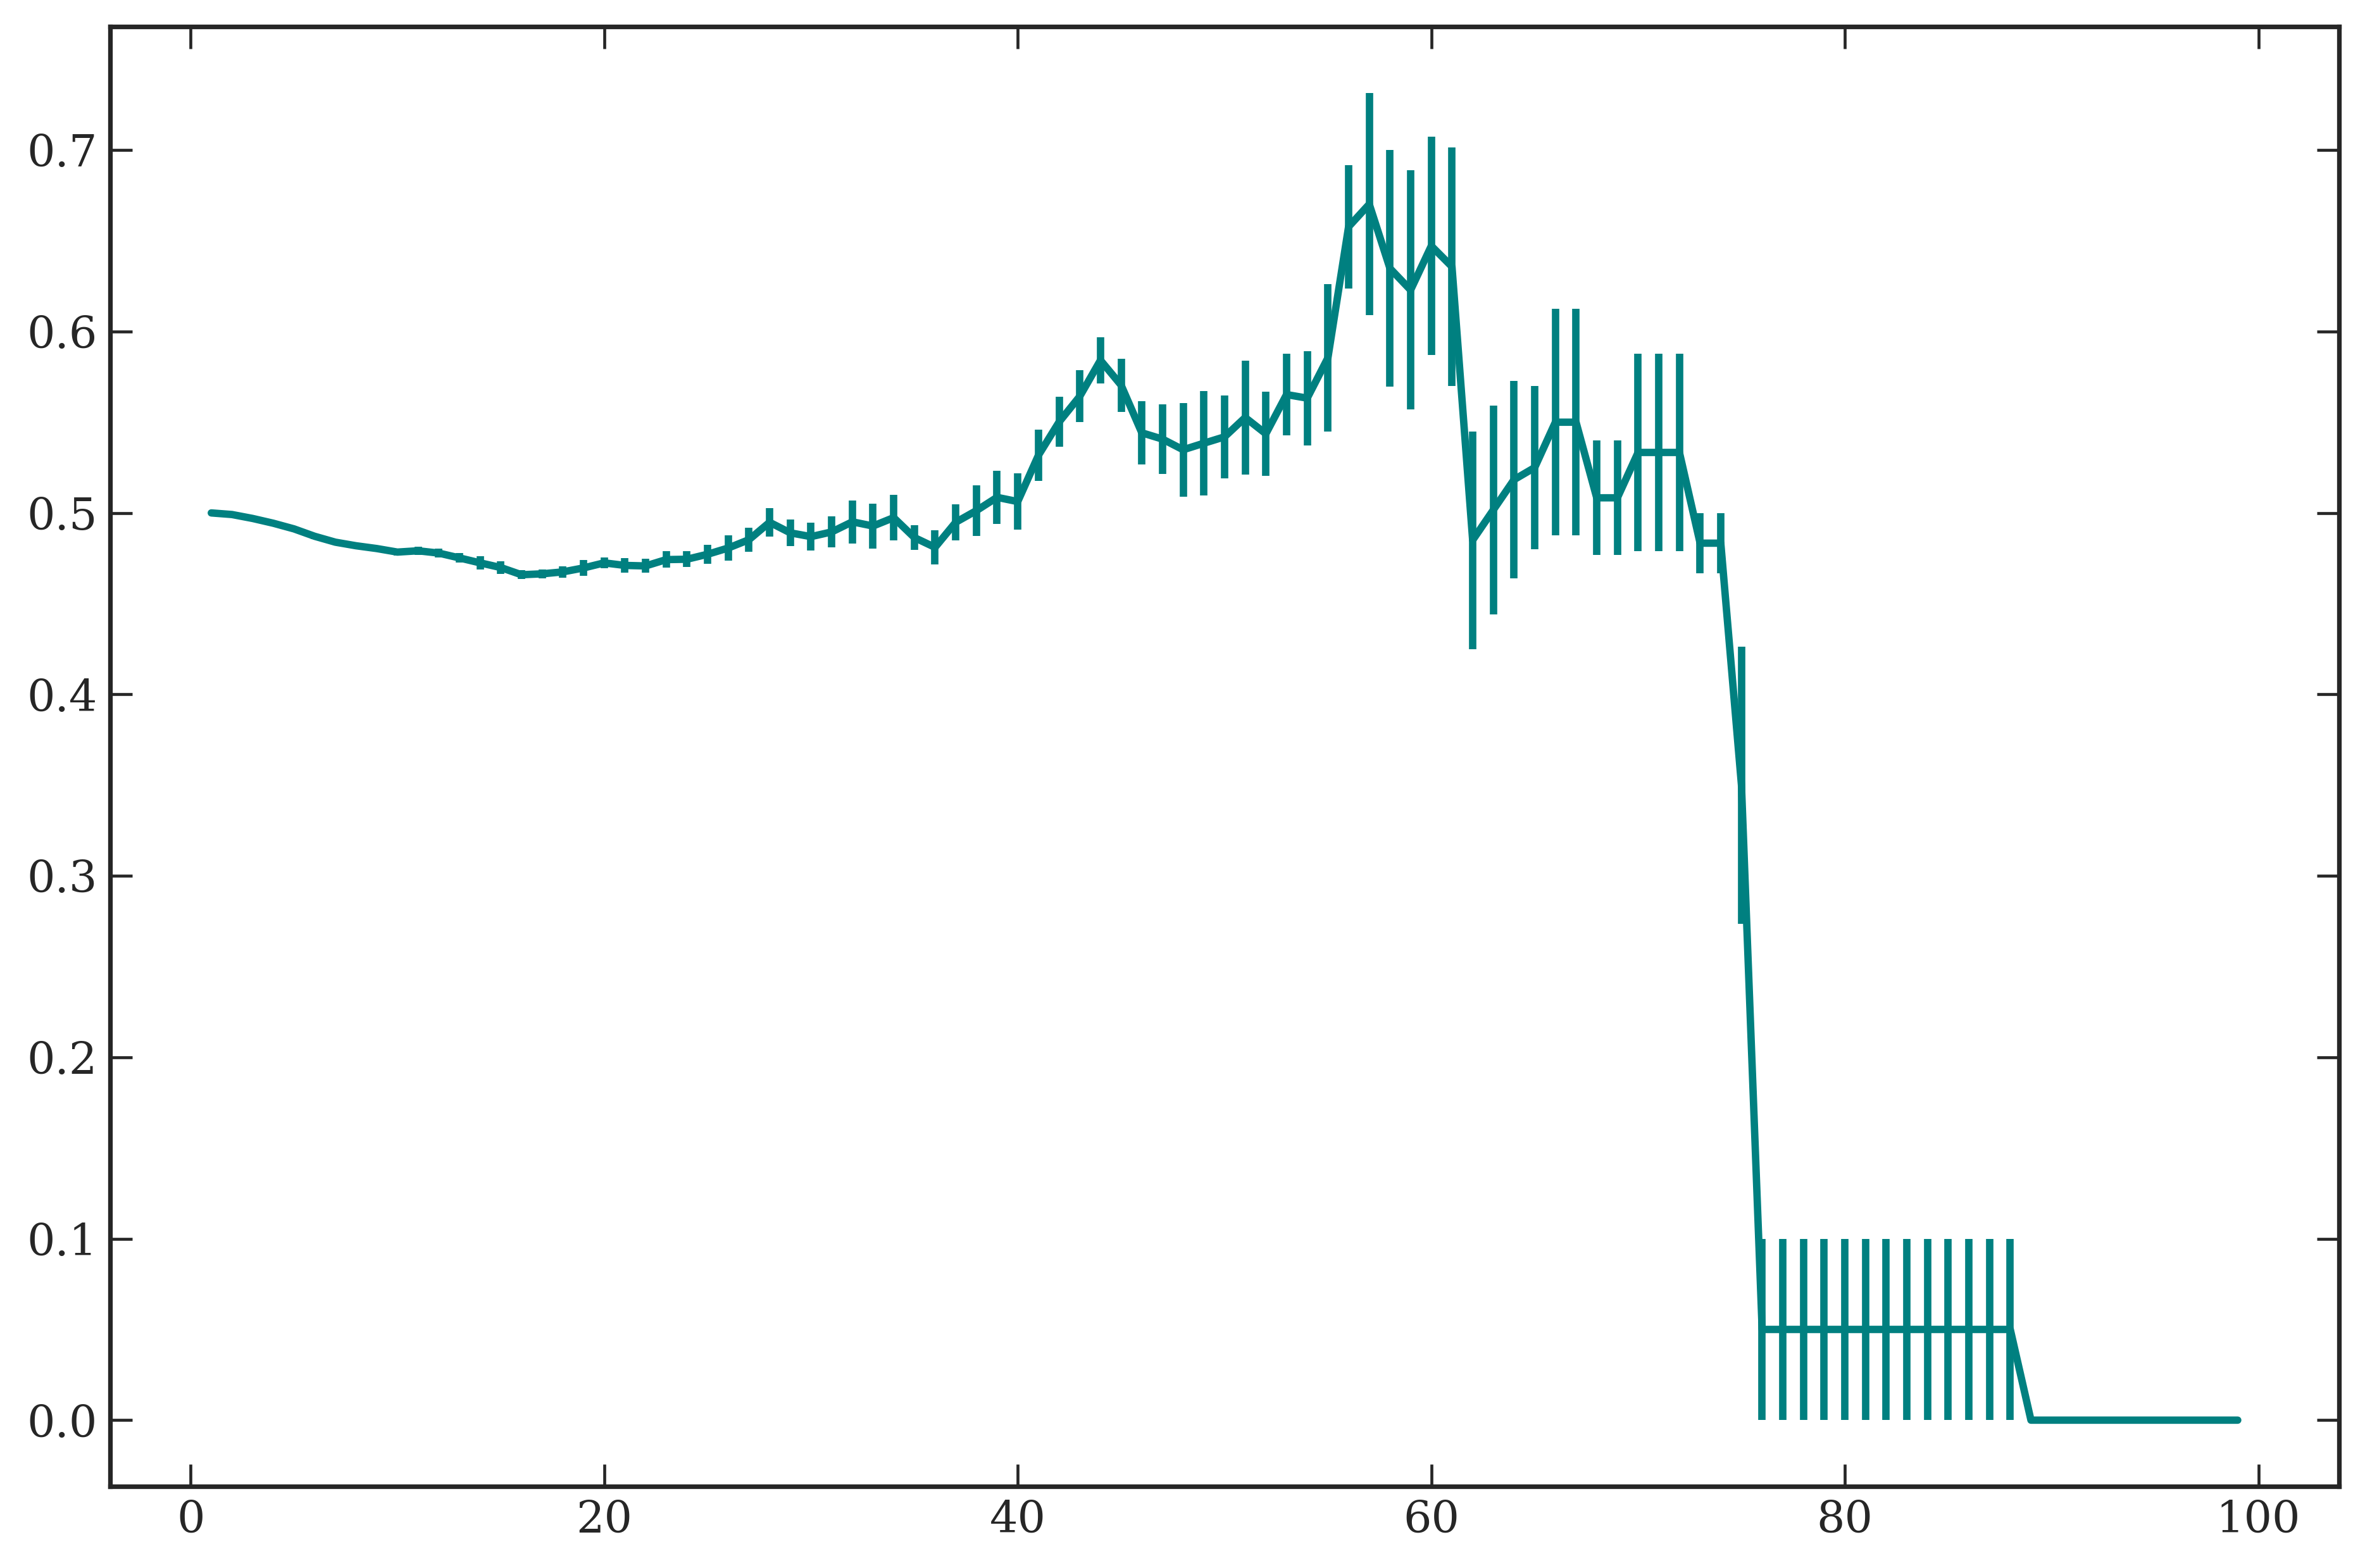

In [60]:
method_kwargs = dict(n_clusters=None, linkage = 'single',)
rmax_list = np.arange(1,100)
cl_list = get_clustering_signed(defect_positions[:10], rmax_list=rmax_list, method=AgglomerativeClustering, method_kwargs=method_kwargs)

qav = np.nanmean(cl_list[:, :, 1], axis = 0)
qtsd = np.nanstd(cl_list[:, :, 1], axis = 0, ddof = 1) / np.sqrt(cl_list.shape[0])
plt.errorbar(rmax_list, qav, yerr = qtsd)

In [ ]:
Ncl = np.max(labels) + 1
Qc_arr = np.zeros(Ncl)
for N in range(Ncl):
    mask = (labels[0] == N)
    Ndefects = np.sum(mask)
    Qc = np.sum(charges[0][mask])
    Qc_arr[N] = Qc
Qcl = np.sum(np.abs(Qc_arr)) / Ncl
Qcl

In [10]:
def_arr = get_defect_arr_from_frame(defect_positions[0], return_charge = True)

In [3]:

rm_list = []

Nclusters = 250
Ncmin = 1
Nframes = 1501
Ndefects = 0
for i, input in enumerate(os.listdir(d_cluster['path'])):
    path = os.path.join(d_cluster['path'], input)
    if i == 0:

        print(f'Analyzing {input}')
        # Load data
        
        for file in os.listdir(path):
            if file.startswith('labels'):
                rm = int(file.split('rm')[-1].split('.')[0])
                if 2 < rm < 150:
                    rm_list.append(int(file.split('rm')[-1].split('.')[0]))

        cluster_arr = np.nan * np.zeros([Nframes, Nclusters - Ncmin, len(rm_list), len(os.listdir(d_cluster['path']))])
        num_clusters = np.zeros([Nframes, len(rm_list), len(os.listdir(d_cluster['path']))])

    with open(os.path.join(path, 'defect_positions.pkl'), 'rb') as f:
        defect_positions = pickle.load(f)

    for k, dist in enumerate(rm_list):
        with open(os.path.join(path, f'labels_rm{dist}.pkl'), 'rb') as f:
            labels = pickle.load(f)
        for j, frame in enumerate(labels):

            if k == 0:
                Ndefects += len(defect_positions[j])

            unique, counts = np.unique(frame, return_counts=True)
            valid_clusters_mask = (counts >= Ncmin)
            num_clusters[j, k, i] = len(unique[valid_clusters_mask])

            # count the number of clusters of each size
            cluster_sizes, cluster_counts = np.unique(counts[valid_clusters_mask], return_counts=True)

            cutoff_mask = (cluster_sizes > Nclusters - 1)
            count_upper  = cutoff_mask.sum()

            cluster_arr[j, cluster_sizes[~cutoff_mask], k, i] = cluster_counts[~cutoff_mask]
            cluster_arr[j, -1, k, i] = count_upper


cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
cluster_arr_std = np.nanstd(cluster_arr, axis = (0,-1)) #/ np.sqrt(cluster_arr.shape[0]*cluster_arr.shape[1])

num_cluster_av = np.mean(num_clusters, axis = (0,-1))
num_cluster_std = np.std(num_clusters, axis = (0,-1))/np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])

Analyzing zeta_0.022_counter_0


C:\Users\Simon Andersen\AppData\Local\Temp\ipykernel_17188\1887257081.py:48: RuntimeWarning: Mean of empty slice
  cluster_arr_av = np.nanmean(cluster_arr, axis = (0,-1))
c:\Users\Simon Andersen\miniconda3\envs\sf\lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [24]:
Nupper = 101 - Ncmin

ff = 0

Nmembers_arr = np.nansum(cluster_arr[ff:, :, :, :], axis=(0,-1)) * np.arange(Ncmin, Nclusters)[:, None] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)
Nmembers_above = Nmembers_arr[Nupper:,:].sum(axis = 0)
Nmembers_arr = Nmembers_arr[:Nupper,:] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)
Nmembers_arr[Nupper - 1,:] += Nmembers_above

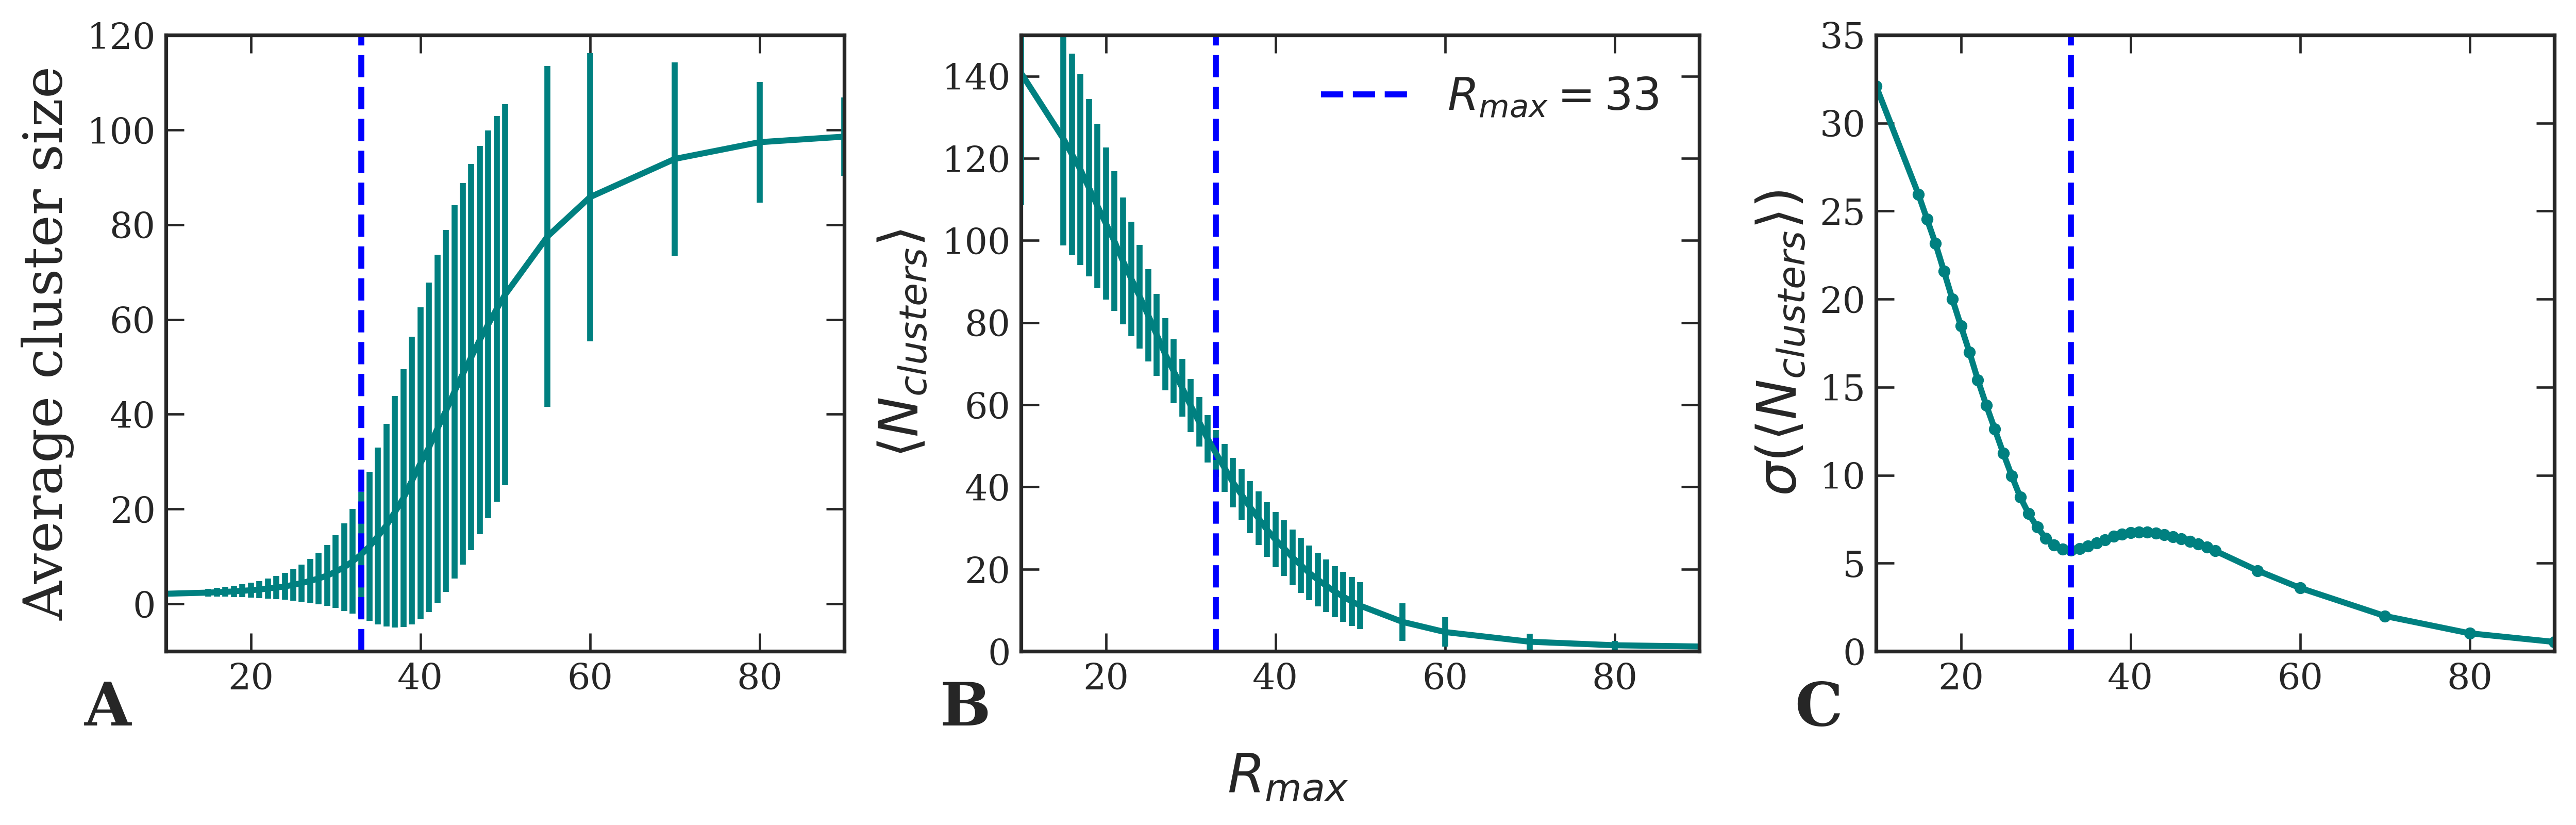

In [25]:
fig, ax = plt.subplots(nrows = 1,ncols=3, figsize=(12, 4.))
ax = ax.flatten()
Nmembers = Nmembers_arr[:, :] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)

cluster_count = Nmembers * np.arange(Ncmin, Nupper + Ncmin) [:, None]
av_cluster_size = np.sum(Nmembers * np.arange(Ncmin, Nupper + Ncmin)[:,None], axis=0) / Nmembers.sum(axis=0)
std_cluster_size = np.sqrt(np.sum(Nmembers * ((np.arange(Ncmin, Nupper + Ncmin)[:,None] - av_cluster_size[None,:])**2), axis=0)\
                            / Nmembers.sum(axis=0),)


dy = np.diff(av_cluster_size)
dx = np.diff(rm_list)
nc_std = num_cluster_std *np.sqrt(num_clusters.shape[0] * num_clusters.shape[1])
min_idx = np.argwhere(np.diff(nc_std) > 0)[0][0] 


ax[0].errorbar(rm_list, av_cluster_size, std_cluster_size, label = 'Average cluster size')
ax[1].errorbar(rm_list, num_cluster_av, nc_std,)
ax[2].plot(rm_list, nc_std, '.-')

for n, axx in enumerate(ax):
    ax[n].text(-0.12, -.12, string.ascii_uppercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')

fig.supxlabel(r'$R_{max}$', y=0.06)
m_list = [120, 150, 35]
ylim_list = [(-10,120), (0, 150), (0, 35)]
ylabel_list = ['Average cluster size', r'$\langle N_{clusters} \rangle$', r'$\sigma(\langle N_{clusters} \rangle)$']

for j, axx in enumerate(ax):
    axx.set_ylim(ylim_list[j])
    axx.set_xlim([10,90])
    axx.set_ylabel(ylabel_list[j])
    axx.set_xticks(np.arange(20,100,20), np.arange(20,100,20))
    axx.vlines(rm_list[min_idx], ylim_list[j][0], m_list[j], label = r'$R_{max} = 33$', linestyles = 'dashed', color = 'b')
ax[1].legend()
plt.tight_layout()  

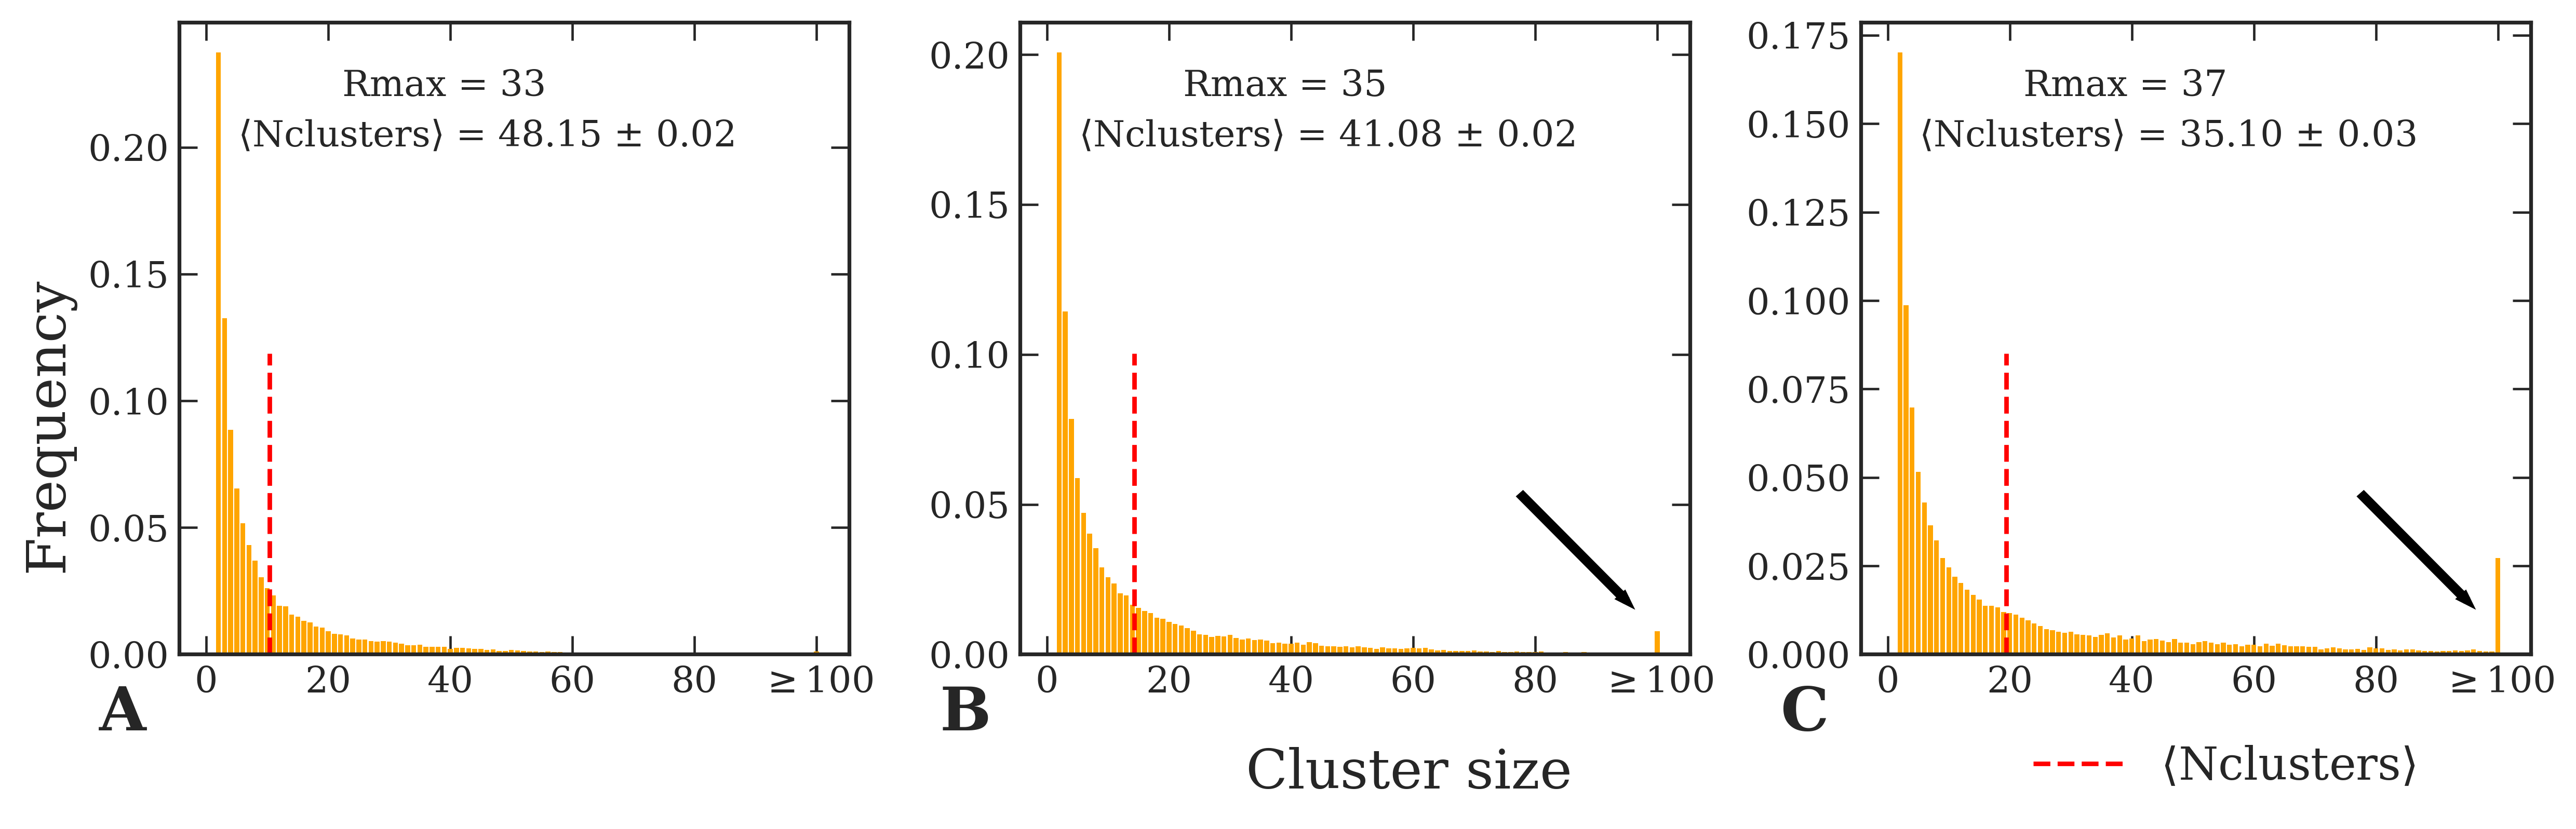

In [49]:
ncols = 3
rm_res = rm_list[16:28]

rm_res = [33, 35, 37]
nrows = int(np.ceil(len(rm_res)/ncols))


fig, ax = plt.subplots(ncols=ncols,nrows=nrows, figsize=(12, 4))
#fig, ax = plt.subplot_mosaic("AB;CD", figsize=(8, 6))
ax = ax.flatten()
for i, dist in enumerate(rm_res):
    idx = rm_list.index(dist)

    Nmembers = Nmembers_arr[:, idx] #, axis = 0) #/ np.sum(cluster_arr[ff:, nc_min:, :, :].mean(axis=(0,-1)), axis = 0)

    cluster_count = Nmembers * np.arange(Ncmin, Nupper + Ncmin)
    av_cluster_size = np.sum(Nmembers * np.arange(Ncmin, Nupper + Ncmin)) / Nmembers.sum()
    std_cluster_size = np.sqrt(np.sum(Nmembers * (np.arange(Ncmin, Nupper + Ncmin) - av_cluster_size)**2) / Nmembers.sum())
    
    max_count = np.max(Nmembers / Nmembers.sum())
    label = rf'$\langle$Nclusters$\rangle$' if i == 0 else None
    ax[i].vlines(av_cluster_size, 0, max_count/2, color = 'r', label = label, linestyle='--',lw=1.5)#, label = f'Nclusters = {num_cluster_av[idx]:.2f} $\pm$ {num_cluster_std[idx]:.2f}')
    ax[i].bar(np.arange(Ncmin, Nupper + Ncmin), Nmembers / Nmembers.sum(), color='orange') #, yerr = cluster_arr_std[:,idx],)

    ax[i].text(0.4575, 0.82, rf'$\langle$Nclusters$\rangle$ = {num_cluster_av[idx]:.2f} $\pm$ {num_cluster_std[idx]:.2f}', \
               horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=12)
    ax[i].text(0.395, 0.9, f'Rmax = {dist}', \
               horizontalalignment='center', verticalalignment='center', transform=ax[i].transAxes, fontsize=12)

    ax[i].set(xticks=np.arange(0, 101, 20), xticklabels=[*np.arange(0, 101, 20)[:-1], r'$\geq$100'])

for n, axx in enumerate(ax):
    ax[n].text(-0.12, -.12, string.ascii_uppercase[n], transform=ax[n].transAxes,
            size=20, weight='bold')
    if n > 0:
        ax[n].arrow(0.75, 0.25, .15, -.16, transform=ax[n].transAxes, lw = 3)
fig.supxlabel('Cluster size', x = 0.55, y=0.07)#25)
fig.supylabel('Frequency', x = 0.02);
fig.legend(ncol = 1, bbox_to_anchor = (0.95, 0.18))
fig.tight_layout()